<a href="https://colab.research.google.com/github/anathayna/tcc/blob/main/tcc_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="orange">**TCC: Classificação do discurso de ódio em memes (treinamento)**</font>

O Google Colab é uma plataforma baseada em Jupyter Notebook que oferece um ambiente de execução em nuvem com recursos gratuitos de GPU e TPU, amplamente utilizado em projetos de aprendizado de máquina e ciência de dados.

Este notebook documenta a etapa de treinamento do trabalho de conclusão de curso, cujo objetivo é classificar discursos de ódio em memes por meio de técnicas de aprendizado de máquina multimodal.

# <font color="orange">**Sumário**</font>

1.   Instalando bibliotecas e dependências
2.   Preparando o banco de dados
3.   Pré-processamento
4.   Treinamento
5.   Classificação
6.   Avaliação
7.   Conclusão

## <font color="orange">1. Instalando bibliotecas e dependências</font>

In [141]:
!pip install ftfy regex tqdm

In [142]:
!pip install googletrans==4.0.0-rc1

In [143]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-08pagyu4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-08pagyu4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [144]:
!pip install jsonlines

In [145]:
from googletrans import Translator
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

## <font color="orange">2. Preparando o banco de dados</font>

O banco de dados utilizado para a identificação do discurso de ódio em memes é o **Hateful Memes** disponibilizado pela Meta no *Challenge Hateful Memes*, um banco de dados com mais de **10 mil** imagens de memes em inglês, que contêm conteúdo ofensivo relacionado a gênero, raça, religião, orientação sexual, classe social e outros tópicos.

E o conjunto de dados é composto pelas seguintes porcentagens:

- **40%** de memes de ódio multimodal (multimodal hate): memes em que tanto o texto quanto a imagem contribuem para a mensagem de ódio.

- **10%** de memes de ódio unimodal (unimodal hate): memes em que apenas uma das modalidades (texto ou imagem) é suficiente para transmitir o discurso de ódio.

- **20%** de memes com confusão de texto benigna (benign text confounder): memes em que o texto foi alterado para remover o discurso de ódio, mas a imagem ainda pode sugerir um significado ofensivo.

- **20%** de memes com confusão de imagem benigna (benign image confounder): memes em que a imagem foi alterada para remover o discurso de ódio, mas o texto ainda pode sugerir um significado ofensivo.

- **10%** de memes não odiosos aleatórios (random non-hateful): memes que não contêm discurso de ódio, escolhidos aleatoriamente.


Um **confundidor benigno** é, basicamente, uma alteração mínima feita em um meme (seja mudando o texto ou a imagem) que faz com que a classificação dele mude de “odioso” para “não odioso”. A alteração é a menor possível, justamente para garantir que a diferença entre o meme odioso e o benigno seja bem sutil e dependa de uma análise genuína das duas modalidades (texto+imagem).


![](https://drivendata-public-assets.s3.amazonaws.com/memes-overview.png)


**Figura 1:** Exemplo de meme utilizado na competição  
Fonte: DRIVENDATA (2020)

Na figura 1, é possível visualizar que o confundidor benigno de texto altera o texto e mantém a imagem, enquanto o confundidor benigno de imagem altera a imagem e mantém o texto.

Baixe o banco de dados do **Hateful Memes** pela plataforma *Kaggle* no seguinte endereço: https://www.kaggle.com/datasets/williamberrios/hateful-memes

Originalmente, esse conjunto de dados estava disponível no site oficial do desafio (https://hatefulmemeschallenge.com/#download). Entretanto, no momento da elaboração desta pesquisa, o domínio encontrava-se indisponível.

In [146]:
#@markdown Defina o caminho para o arquivo **.zip** do banco de dados do *Hateful Memes*.
#@markdown **exemplo:** `"/content/drive/MyDrive/hateful_memes.zip"`

PATH_TO_ZIP_FILE = '/content/drive/MyDrive/hateful_memes.zip' #@param {type:"string"}

#@markdown Defina o diretório base para extrair o banco de dados.
#@markdown **exemplo:** `"/content"`

HOME = '/content' #@param {type:"string"}

Após realizar o download do banco de dados e armazená-lo no Google Drive, é necessário integrá-lo ao ambiente do Google Colab para extração das características. Para isso, utilizamos a biblioteca google.colab.drive, que permite montar o Google Drive como um sistema de arquivos virtual no ambiente de execução.

Ao executar o código, o Colab solicitará uma autorização para acessar sua conta do Google Drive. Uma vez concedida a permissão, o Drive será vinculado ao diretório `/content/drive/`, possibilitando a leitura dos arquivos armazenados. Essa abordagem garante acesso contínuo aos dados durante o processamento, sem necessidade de uploads manuais.

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Agora, preparamos o ambiente para incorporar a pasta "model", que armazenará o banco de dados e outros arquivos essenciais, garantindo que o projeto possa acessá-los corretamente.

In [148]:
import os
os.chdir(HOME)
os.getcwd()
os.environ['PYTHONPATH'] += ":/content/model/"

Em seguida, o código realiza a extração automática do banco de dados Hateful Memes (armazenado no formato `.zip`) para o diretório `/content/model/`, disponibilizando os arquivos para as próximas etapas de processamento e análise no notebook.

In [149]:
import zipfile
zip_path = PATH_TO_ZIP_FILE
extract_path = '/content/model/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [150]:
img_dir = '/content/model/hateful_memes/img'

image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']

image_count = 0
for filename in os.listdir(img_dir):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

print(f"total de imagens: {image_count}")

total de imagens: 12140


Após extrair o conteúdo do arquivo ZIP do dataset, é possível verificar que ele contém **12.140** imagens, inclui também a licença de uso, que especifica as regras de utilização, além de arquivos essenciais para o treinamento e avaliação. A estrutura do dataset é a seguinte:

- Pasta `img/` — contém as imagens (formato .png) correspondentes aos memes.
- Arquivos `.jsonl`:
  - **train.jsonl** — conjunto de treinamento, com rótulos disponíveis (0 = non-hateful, 1 = hateful)
  - **dev_seen.jsonl** — conjunto de validação (seen)
  - **dev_unseen.jsonl** — conjunto de validação (unseen)
  - **test_seen.jsonl** — conjunto de teste (seen), sem rótulos
  - **test_unseen.jsonl** — conjunto de teste (unseen), sem rótulos

O formato .jsonl (JSON Lines) significa que cada linha é um objeto JSON independente, ou seja, cada linha representa um exemplo de meme, com campos como id, text, img (caminho da imagem, por exemplo, "img/42953.png") e, quando aplicável, label que representa os rótulo (0 ou 1).

Os termos “seen” (“visto”) e “unseen” (“não visto”) indicam se os memes foram “expostos” durante a fase de desenvolvimento ou não.
- **“Seen”** refere-se a memes que já estiveram visíveis publicamente durante o desenvolvimento.
- **“Unseen”** são memes inéditos, usados para avaliar generalização em dados mais desafiadores ou que não foram expostos previamente.

Os conjuntos de validação são utilizados para medir o desempenho do modelo durante o desenvolvimento, enquanto os conjuntos de teste servem para avaliação final, sem que o modelo conheça os rótulos.

In [151]:
import jsonlines

base_path = '/content/model/hateful_memes/'

def read_jsonl_to_dataframe(jsonl_path):
    data = []
    with jsonlines.open(jsonl_path) as reader:
        for obj in reader:
            data.append(obj)
    return pd.DataFrame(data)

df_train = read_jsonl_to_dataframe(os.path.join(base_path, "train.jsonl"))
df_dev_seen = read_jsonl_to_dataframe(os.path.join(base_path, "dev_seen.jsonl"))
df_dev_unseen = read_jsonl_to_dataframe(os.path.join(base_path, "dev_unseen.jsonl"))
df_test_seen = read_jsonl_to_dataframe(os.path.join(base_path, "test_seen.jsonl"))
df_test_unseen = read_jsonl_to_dataframe(os.path.join(base_path, "test_unseen.jsonl"))

df_train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [152]:
print(f"Total entries in train.jsonl: {df_train.shape[0]}")
print(f"Total entries in dev_seen.jsonl: {df_dev_seen.shape[0]}")
print(f"Total entries in dev_unseen.jsonl: {df_dev_unseen.shape[0]}")
print(f"Total entries in test_seen.jsonl: {df_test_seen.shape[0]}")
print(f"Total entries in test_unseen.jsonl: {df_test_unseen.shape[0]}")

Total entries in train.jsonl: 8500
Total entries in dev_seen.jsonl: 500
Total entries in dev_unseen.jsonl: 540
Total entries in test_seen.jsonl: 1000
Total entries in test_unseen.jsonl: 2000


In [153]:
df = df_test_seen

value_counts_df = df['label'].value_counts().reset_index()
value_counts_df.columns = ['label', 'count']
value_counts_df['%'] = (value_counts_df['count'] / value_counts_df['count'].sum() * 100).map('{:.2f}'.format)
display(value_counts_df.style.hide(axis='index'))

label,count,%
0,510,51.00
1,490,49.00


## <font color="orange">3. Pré-processamento</font>

No primeiro experimento, realizado com a classificação zero-shot do modelo, observou-se que a label binária entre "discurso de ódio" e "não discurso de ódio" não era suficiente para capturar a complexidade do dataset.

Os chamados confundidores benignos, memes que possuem elementos que podem confundir o modelo, mas não configuram discurso de ódio, exigem um tratamento específico.

Portanto, propõe-se um pré-processamento, no qual serão criadas novas labels para melhorar o treinamento do modelo e obter uma acurácia e uma matriz de confusão melhor.

Primeiro os textos dos memes são transformados em índices numéricos, criando dicionários para converter textos únicos em índices.

In [154]:
idx_to_text = {idx:text for idx, text in enumerate(df['text'].unique())}
text_to_idx = {v:k for k, v in idx_to_text.items()}
df['text_idx'] = df['text'].map(text_to_idx)
df.head()

,id,img,label,text,text_idx
0,16395,img/16395.png,1,handjobs sold seperately,0
1,37405,img/37405.png,1,introducing fidget spinner for women,1
2,94180,img/94180.png,1,happy pride month let's go beat up lesbians,2
3,54321,img/54321.png,1,laughs in [majority of u.s crime rate],3
4,97015,img/97015.png,1,finds out those 72 virgins.. are goats,4


Visualização da distribuição dos textos mais comuns na base:

In [155]:
translator = Translator()

top10_idx = df['text_idx'].value_counts().index[:10]
top10_counts = df['text_idx'].value_counts().iloc[:10].values
textos = [idx_to_text[idx] for idx in top10_idx]

translate = []
for text in textos:
    translation = translator.translate(text, src='en', dest='pt').text
    translate.append(translation)

top10_df = pd.DataFrame({
    'text_idx': top10_idx,
    'text': textos,
    'translate': translate,
    'count': top10_counts
})
display(top10_df)

,text_idx,text,translate,count
0,183,leave that one alone bill he's my weed man,"deixe esse em paz, Bill, ele é meu homem da ma...",3
1,233,party tonight? i'm down,festa esta noite?estou triste,3
2,353,when dishwasher stops working take it back,quando a máquina de lavar louça parar de funci...,3
3,766,when mom asks where all the jews went,quando a mãe pergunta para onde foram todos os...,2
4,721,the closest some of us will ever get to heaven,o mais próximo que alguns de nós chegaremos do...,2
5,756,"it's taekwondo, not taekwondon't","é taekwondo, não taekwondo, não",2
6,763,i hate it when white people throw gang signs t...,eu odeio quando brancos fazem cartazes de gang...,2
7,720,1939-1945 bake off winner,Vencedor do bolo de 1939-1945,2
8,715,don't be racist black and white children are t...,"não seja racista, crianças negras e brancas sã...",2
9,691,women use chemicals to remove polish everyday ...,as mulheres usam produtos químicos para remove...,2


In [156]:
text_idx_to_memes = df.groupby('text_idx')['id'].apply(list).to_dict()
text_idx_to_memes = {k:v for k, v in text_idx_to_memes.items() if len(v) > 1}
print(f"text_idx com mais de um meme associado: {len(text_idx_to_memes)}")

df_indexed = df.set_index('id')

text_idx_to_label_to_memes = {}
for text_idx, memes in text_idx_to_memes.items():
    text_idx_to_label_to_memes[text_idx] = {}
    text_idx_to_label_to_memes[text_idx]['non-hateful'] = []
    text_idx_to_label_to_memes[text_idx]['hateful'] = []

    hateful_added, non_hateful_added = False, False
    for meme_idx in memes:
        if df_indexed.loc[meme_idx]['label'] == 0:
            text_idx_to_label_to_memes[text_idx]['non-hateful'].append(meme_idx)
            non_hateful_added = True
        else:
            text_idx_to_label_to_memes[text_idx]['hateful'].append(meme_idx)
            hateful_added = True

    if not hateful_added or not non_hateful_added:
        del text_idx_to_label_to_memes[text_idx]

print(f"text_idx com memes hateful e non-hateful associados (confundidores benignos): {len(text_idx_to_label_to_memes)}")

text_idx com mais de um meme associado: 168
text_idx com memes hateful e non-hateful associados (confundidores benignos): 149


TOP 10 itens do dicionário `text_idx_to_label_to_memes`, que contém os índices de texto e as listas de IDs de memes associados a cada rótulo ('non-hateful' e 'hateful').

In [157]:
data = []
for text_idx, labels_and_memes in list(text_idx_to_label_to_memes.items())[:10]:
    data.append({
        'text_idx': text_idx,
        'non-hateful memes': labels_and_memes['non-hateful'],
        'hateful memes': labels_and_memes['hateful']
    })

df_text_idx_label_memes = pd.DataFrame(data)
display(df_text_idx_label_memes)

,text_idx,non-hateful memes,hateful memes
0,102,[42615],[23419]
1,105,[10865],[64735]
2,106,[10652],[39564]
3,107,[85471],[92456]
4,110,[15379],[70143]
5,111,[63719],[51863]
6,112,[76091],[02584]
7,113,[57431],[48132]
8,114,[45792],[81370]
9,116,[50643],[07193]


Um exemplo onde 3 memes com o mesmo texto possuem rótulos distintos (df_train).

In [158]:
# translator = Translator()

# meme_ids_to_show = ['34217', '74386', '39625']

# num_images = len(meme_ids_to_show)

# fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 8))

# if num_images == 1:
#     axes = [axes]

# translations = []

# for i, meme_id in enumerate(meme_ids_to_show):
#     if meme_id in df_indexed.index:
#         meme_info = df_indexed.loc[meme_id]

#         img_path = f'{img_dir}/{meme_info["img"].split("/")[-1]}'
#         text = meme_info['text']
#         label = 'hateful' if meme_info['label'] == 1 else 'non-hateful'
#         translation = translator.translate(text, src='en', dest='pt').text

#         translations.append(f"translation: {translation}")

#         axes[i].imshow(Image.open(img_path))
#         axes[i].set_title(f'ID: {meme_id} ({label})')
#         axes[i].axis('off')


# plt.tight_layout()
# plt.show()

# print(translations[0])

Exibição de um meme individual com base em seu ID, imagem, texto original, rótulo (hateful ou non-hateful) e a tradução do texto para o português. Útil para inspecionar memes específicos do dataset.

In [159]:
# translator = Translator()

# meme_id = '10865'

# meme_info = df_indexed.loc[meme_id]

# print(meme_info)

# img_path = f'{img_dir}/{meme_info["img"].split("/")[-1]}'
# text = meme_info['text']
# label = 'hateful' if meme_info['label'] == 1 else 'non-hateful'

# translation = translator.translate(text, src='en', dest='pt').text

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(Image.open(img_path))
# ax.set_title(f'ID: {meme_id}')
# ax.text(0, -30, f"label: {label}\ntranslate: {translation}", wrap=True)
# ax.axis('off')
# plt.show()

Seleção randomica de um par de memes (um "hateful" e um "non-hateful") que compartilham o mesmo texto (confundidores benignos).

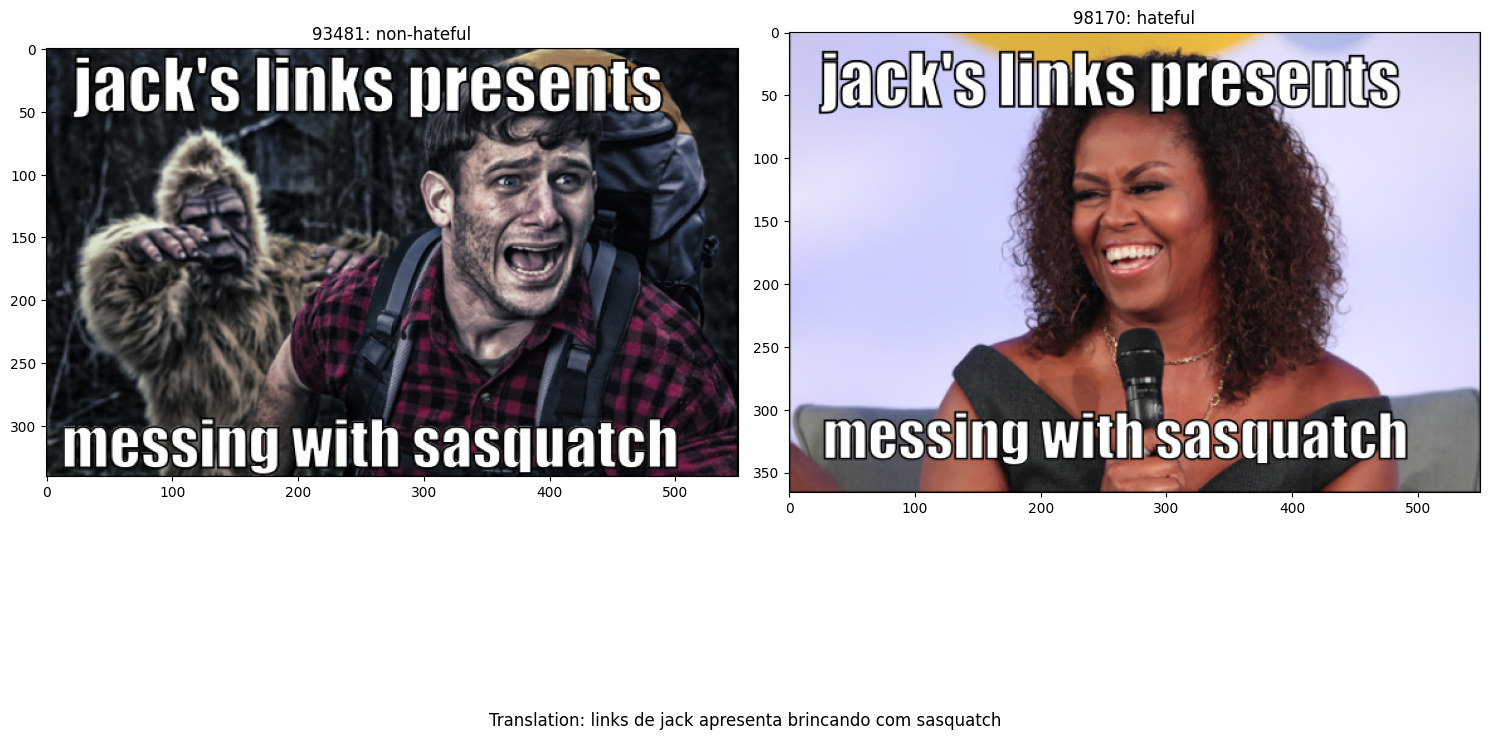

In [160]:
translator = Translator()

sample_text_idx = np.random.choice(list(text_idx_to_label_to_memes.keys()))

non_hateful_memes = text_idx_to_label_to_memes[sample_text_idx]['non-hateful']
hateful_memes = text_idx_to_label_to_memes[sample_text_idx]['hateful']

meme_idx_1 = np.random.choice(non_hateful_memes) if non_hateful_memes else None
meme_idx_2 = np.random.choice(hateful_memes) if hateful_memes else None

original_text = idx_to_text[sample_text_idx]
single_translation = translator.translate(original_text, src='en', dest='pt').text

fig, axes = plt.subplots(1, 2, figsize=(15,10))

if meme_idx_1:
    img_path_1 = f'{img_dir}/{meme_idx_1}.png'
    text_1 = df_indexed.loc[meme_idx_1]['text']
    label_1 = 'non-hateful'

    axes[0].imshow(Image.open(img_path_1))
    axes[0].set_title(f'{meme_idx_1}: {label_1}')


if meme_idx_2:
    img_path_2 = f'{img_dir}/{meme_idx_2}.png'
    text_2 = df_indexed.loc[meme_idx_2]['text']
    label_2 = 'hateful'

    axes[1].imshow(Image.open(img_path_2))
    axes[1].set_title(f'{meme_idx_2}: {label_2}')


plt.tight_layout()
plt.suptitle(f"Translation: {single_translation}", y=0.05, ha='center', va='top')
plt.show()

# Agrupando similaridades de texto

Utilizando o modelo pré-treinado `all-mpnet-base-v2` para transformar os textos da coluna 'text' do df em embeddings, ou seja, representações numéricas que capturam o significado semântico de cada frase. Esses vetores permitem comparar a similaridade entre diferentes textos de forma mais precisa, beneficiando etapas posteriores de treinamento, análise e agrupamento.

In [161]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2", device="cuda" if torch.cuda.is_available() else "cpu")
sentences = df['text'].tolist()
embeddings = model.encode(sentences, batch_size=32, convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Esse trecho calcula a matriz de similaridade de cosseno entre todos os embeddings usando a função `pytorch_cos_sim`. O resultado é uma matriz onde cada valor representa o grau de similaridade entre dois textos, permitindo comparar rapidamente quais pares de textos têm maior ou menor proximidade semântica.

In [162]:
from sentence_transformers import util
scores = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()

In [163]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
scores_tr = cosine_similarity(embeddings)
for i in range(len(scores_tr)):
    scores_tr[i, i] = 0
print(scores_tr.shape)
print(scores_tr.min(), scores_tr.max())

(1000, 1000)
-0.19682403 1.0000005


Este bloco define um limiar de similaridade (threshold) de 0.7 para selecionar pares de textos cuja similaridade de cosseno seja maior que esse valor.

In [164]:
threshold = 0.7
i_idxs, j_idxs = np.where(scores_tr > threshold)

pairs = list(zip(i_idxs, j_idxs))

In [165]:
cluster_text_idx_to_meme_idxs = {}
for i, j in pairs:
    found = False
    for k in range(len(cluster_text_idx_to_meme_idxs)):
        if i in cluster_text_idx_to_meme_idxs[k] or j in cluster_text_idx_to_meme_idxs[k]:
            cluster_text_idx_to_meme_idxs[k].update({i, j})
            found = True
            break
    if not found:
        cluster_text_idx_to_meme_idxs[len(cluster_text_idx_to_meme_idxs)] = {i, j}

print(f"clusters formados: {len(cluster_text_idx_to_meme_idxs)}")

clusters formados: 198


In [166]:
meme_idx_to_cluster_text_idx = {}
for cluster_text_idx, meme_idxs in cluster_text_idx_to_meme_idxs.items():
    for meme_idx in meme_idxs:
        meme_idx_to_cluster_text_idx[meme_idx] = cluster_text_idx

print(f"Número de memes cobertos inicialmente pelo mapeamento de clusters: {len(meme_idx_to_cluster_text_idx)}")

non_covered_meme_idxs = set(df['id'].values) - set(meme_idx_to_cluster_text_idx.keys())
for i, non_covered_meme_idx in enumerate(non_covered_meme_idxs, start=len(cluster_text_idx_to_meme_idxs)):
    meme_idx_to_cluster_text_idx[non_covered_meme_idx] = i

print(f"Número total de memes cobertos após adicionar os não agrupados: {len(meme_idx_to_cluster_text_idx)}")

Número de memes cobertos inicialmente pelo mapeamento de clusters: 430
Número total de memes cobertos após adicionar os não agrupados: 1430


In [167]:
df['cluster_text_idx'] = df['id'].map(meme_idx_to_cluster_text_idx)

In [168]:
df.describe()

,label,text_idx,cluster_text_idx
count,1000.00000,1000.000000,1000.000000
mean,0.49000,403.777000,697.500000
std,0.50015,231.679634,288.819436
min,0.00000,0.000000,198.000000
25%,0.00000,204.000000,447.750000
50%,0.00000,395.000000,697.500000
75%,1.00000,598.250000,947.250000
max,1.00000,828.000000,1197.000000


In [169]:
df.head()

,id,img,label,text,text_idx,cluster_text_idx
0,16395,img/16395.png,1,handjobs sold seperately,0,231
1,37405,img/37405.png,1,introducing fidget spinner for women,1,272
2,94180,img/94180.png,1,happy pride month let's go beat up lesbians,2,279
3,54321,img/54321.png,1,laughs in [majority of u.s crime rate],3,368
4,97015,img/97015.png,1,finds out those 72 virgins.. are goats,4,574


Número de pares com similaridade > 0.7: 550

Exemplos dos primeiros 5 pares com alta similaridade:

Meme IDs: 16395, 50783 | Similaridade: 0.9446
Tradução: punhetas vendidas separadamente


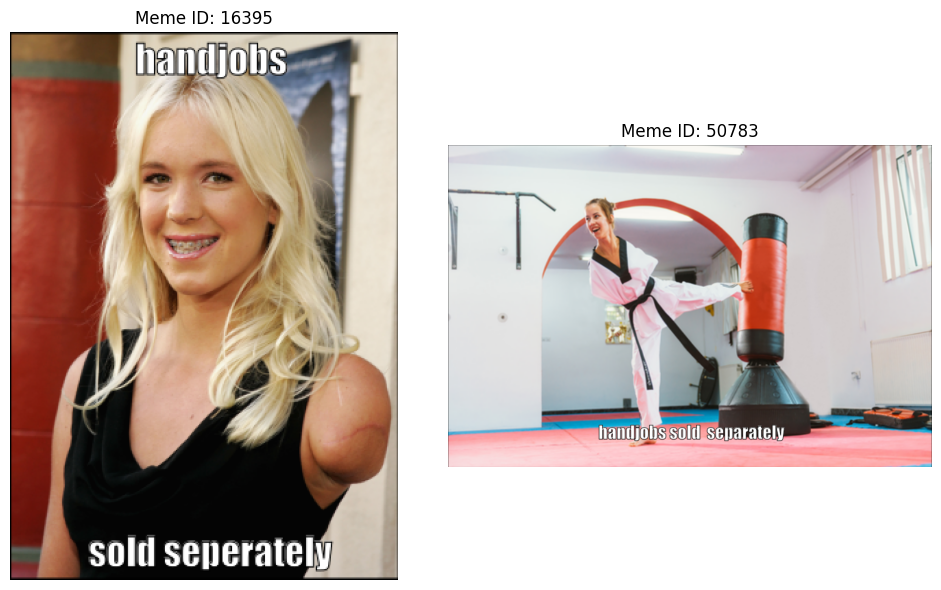

--------------------
Meme IDs: 04615, 93462 | Similaridade: 0.7264
Tradução: é a religião da paz.junte-se ao Islã exclusivo!


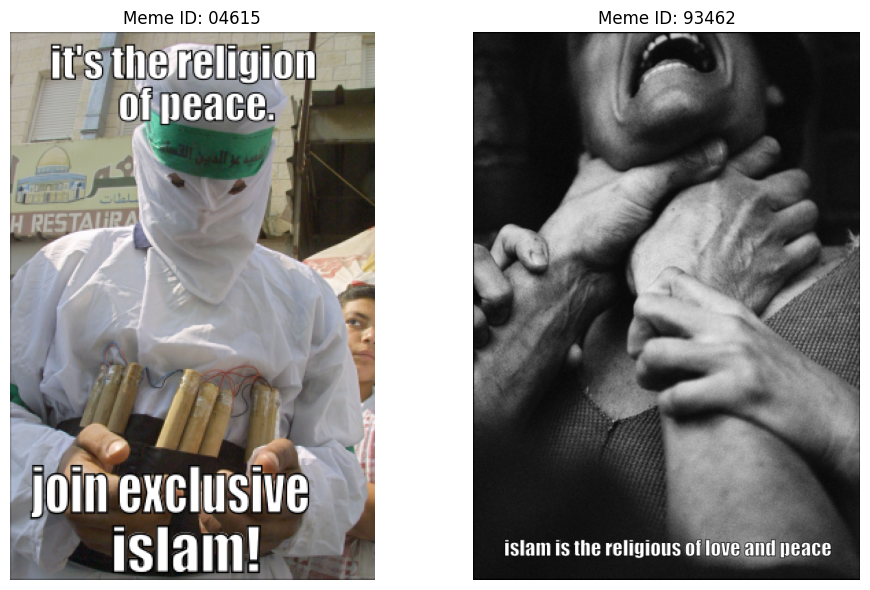

--------------------
Meme IDs: 04615, 86425 | Similaridade: 0.7264
Tradução: é a religião da paz.junte-se ao Islã exclusivo!


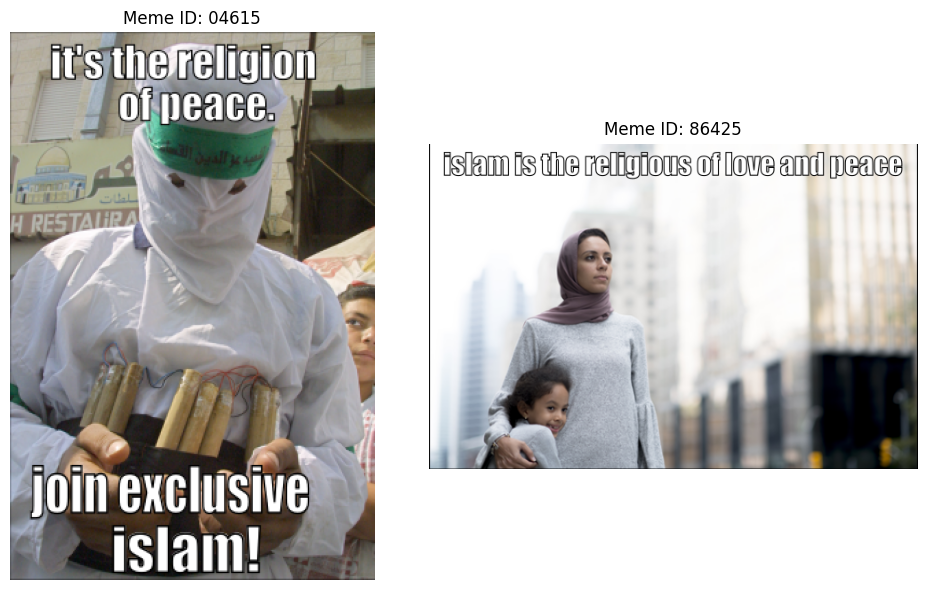

--------------------


In [170]:
translator = Translator()

high_similarity_pairs = np.where(scores_tr > threshold)
i_idxs = high_similarity_pairs[0]
j_idxs = high_similarity_pairs[1]

print(f"Número de pares com similaridade > {threshold}: {len(i_idxs)}")

print("\nExemplos dos primeiros 5 pares com alta similaridade:\n")
for k in range(min(3, len(i_idxs))):
    i = i_idxs[k]
    j = j_idxs[k]

    meme_id_i = df.iloc[i]['id']
    meme_id_j = df.iloc[j]['id']
    text_i = df.iloc[i]['text']
    text_j = df.iloc[j]['text']

    print(f"Meme IDs: {meme_id_i}, {meme_id_j} | Similaridade: {scores_tr[i, j]:.4f}")

    translation_i = translator.translate(text_i, src='en', dest='pt').text
    translation_j = translator.translate(text_j, src='en', dest='pt').text
    print(f"Tradução: {translation_i}")

    img_path_i = f'{img_dir}/{df.iloc[i]["img"].split("/")[-1]}'
    img_path_j = f'{img_dir}/{df.iloc[j]["img"].split("/")[-1]}'

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].imshow(Image.open(img_path_i))
    axes[0].set_title(f'Meme ID: {meme_id_i}')
    axes[0].axis('off')

    axes[1].imshow(Image.open(img_path_j))
    axes[1].set_title(f'Meme ID: {meme_id_j}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print("-" * 20)

# Agrupando similaridades de imagem

In [171]:
!pip install faiss-cpu

In [172]:
from skimage.metrics import structural_similarity as compare_ssim
import imutils
import cv2

In [173]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()

return_nodes = {'avgpool': 'features'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

x = torch.randn([1, 3, 224, 224])
output = feature_extractor(x)['features']
print(output.shape)


torch.Size([1, 512, 1, 1])


In [174]:
data_dir = '/content/model/hateful_memes/'

import torchvision.transforms.v2 as v2
from tqdm import tqdm

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


imgs = []
for img_fp in tqdm(df['img'].values.tolist()):
    img = Image.open(f'{data_dir}/{img_fp}').convert('RGB')
    img = transforms(img).unsqueeze(0)
    imgs.append(img)


100%|██████████| 1000/1000 [00:12<00:00, 80.01it/s]


In [175]:
imgs = torch.cat(imgs, dim=0)
print(imgs.shape)

torch.Size([1000, 3, 224, 224])


In [176]:
batch_size = 100
assert len(imgs) % batch_size == 0
num_batches = len(imgs) // batch_size
imgs_features = []
for i in tqdm(range(num_batches)):
    start_idx = i*batch_size
    end_idx = start_idx + batch_size
    imgs_features_batch = feature_extractor(imgs[start_idx:end_idx])['features']
    imgs_features_batch = imgs_features_batch.squeeze().detach().numpy()
    imgs_features.append(imgs_features_batch)
imgs_features = np.concatenate(imgs_features)
print(imgs_features.shape)

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

(1000, 512)


In [177]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
scores_img = cosine_similarity(imgs_features)
for i in range(len(scores_img)):
    scores_img[i, i] = 0
print(scores_img.shape)
print(scores_img.min(), scores_img.max())

(1000, 1000)
0.0 0.9990256


532
1 636 scores_img: 0.9794121980667114


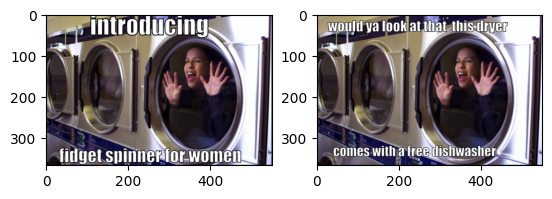

1 720 scores_img: 0.978445291519165


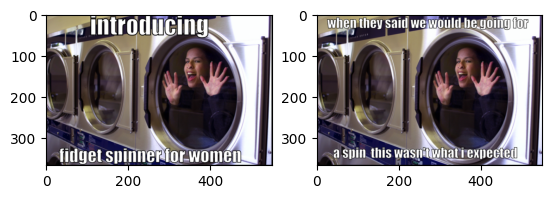

1 829 scores_img: 0.9737560153007507


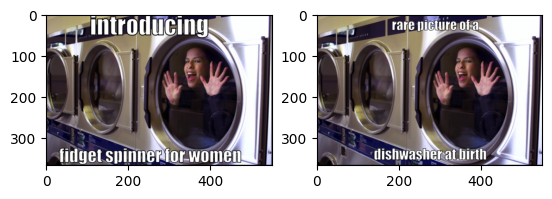

In [178]:
i_idxs, j_idxs = np.where((scores_img>0.92) & (scores_img<1))
print(len(i_idxs))
meme_idx_to_img = df['img'].to_dict()
meme_idxs = list(meme_idx_to_img.keys())
for i, j in zip(i_idxs[:3], j_idxs[:3]):
    print(meme_idxs[i], meme_idxs[j],  f'scores_img: {scores_img[i, j]}')
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(Image.open(f'{data_dir}/{meme_idx_to_img[meme_idxs[i]]}'))
    axes[1].imshow(Image.open(f'{data_dir}/{meme_idx_to_img[meme_idxs[j]]}'))
    plt.show()

In [179]:
meme_idxs = list(meme_idx_to_img.keys())
cluster_img_idx_to_meme_idxs = {}
for i, j in zip(i_idxs, j_idxs):
    for k in range(len(cluster_img_idx_to_meme_idxs)):
        if meme_idxs[i] in cluster_img_idx_to_meme_idxs[k] or meme_idxs[j] in cluster_img_idx_to_meme_idxs[k]:
            cluster_img_idx_to_meme_idxs[k].update({meme_idxs[i], meme_idxs[j]})
            break
    else:
        cluster_img_idx_to_meme_idxs[len(cluster_img_idx_to_meme_idxs)] = {meme_idxs[i], meme_idxs[j]}
print(f"Número de clusters de memes semelhantes encontrados: {len(cluster_img_idx_to_meme_idxs)}")

Número de clusters de memes semelhantes encontrados: 183


In [180]:
meme_idx_to_cluster_img_idx = {}
for cluster_img_idx, meme_idxs in cluster_img_idx_to_meme_idxs.items():
    for meme_idx in meme_idxs:
        meme_idx_to_cluster_img_idx[meme_idx] = cluster_img_idx
print(f"Quantidade de memes associados a clusters após a primeira etapa: {len(meme_idx_to_cluster_img_idx)}")

non_covered_meme_idxs = set(df['id'].values) - set(meme_idx_to_cluster_img_idx.keys())
for i, non_covered_meme_idx in enumerate(non_covered_meme_idxs, start=len(cluster_img_idx_to_meme_idxs)):
    meme_idx_to_cluster_img_idx[non_covered_meme_idx] = i
print(f"Quantidade total de memes após inclusão dos memes não agrupados: {len(meme_idx_to_cluster_img_idx)}")

Quantidade de memes associados a clusters após a primeira etapa: 397
Quantidade total de memes após inclusão dos memes não agrupados: 1397


In [181]:
df['cluster_img_idx'] = df['id'].map(meme_idx_to_cluster_img_idx)

In [182]:
df.head()

,id,img,label,text,text_idx,cluster_text_idx,cluster_img_idx
0,16395,img/16395.png,1,handjobs sold seperately,0,231,216
1,37405,img/37405.png,1,introducing fidget spinner for women,1,272,257
2,94180,img/94180.png,1,happy pride month let's go beat up lesbians,2,279,264
3,54321,img/54321.png,1,laughs in [majority of u.s crime rate],3,368,353
4,97015,img/97015.png,1,finds out those 72 virgins.. are goats,4,574,559


In [183]:
df.nunique()

,0
id,1000
img,1000
label,2
text,829
text_idx,829
cluster_text_idx,1000
cluster_img_idx,1000


## <font color="orange">4. Treinamento</font>

In [184]:
from torch.utils.data import Dataset

class HatefulMemesDataset(Dataset):
    def __init__(self, dataframe, data_dir, clip_tokenizer):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.clip_tokenizer = clip_tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.data_dir, row['img'])
        image = Image.open(img_path).convert('RGB')

        text = row['text']
        label = row['label']
        text_idx = row['text_idx']
        cluster_text_idx = row['cluster_text_idx']
        cluster_img_idx = row['cluster_img_idx']

        image = self.clip_tokenizer(image)

        text_tokens = clip.tokenize(text, truncate=True)


        return {
            'image': image,
            'text': text_tokens.squeeze(0),
            'label': label,
            'text_idx': text_idx,
            'cluster_text_idx': cluster_text_idx,
            'cluster_img_idx': cluster_img_idx
        }

In [185]:
import torch.nn as nn
import torch.nn.functional as F
import clip

class MultimodalModel(nn.Module):
    def __init__(self, num_text_idxs, num_cluster_text_idxs, num_cluster_img_idxs, device):
        super().__init__()

        self.clip_model, self.preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

        clip_feature_dim = 512
        embedding_dim = 64

        self.text_idx_embedding = nn.Embedding(num_text_idxs, embedding_dim)
        self.cluster_text_idx_embedding = nn.Embedding(num_cluster_text_idxs, embedding_dim)
        self.cluster_img_idx_embedding = nn.Embedding(num_cluster_img_idxs, embedding_dim)

        combined_feature_dim = clip_feature_dim * 2 + embedding_dim * 3

        self.classifier = nn.Linear(combined_feature_dim, 1)

    def forward(self, image, text_tokens, text_idx, cluster_text_idx, cluster_img_idx):
        image_features = self.clip_model.encode_image(image).float()
        text_features = self.clip_model.encode_text(text_tokens).float()

        text_idx_embedded = self.text_idx_embedding(text_idx).float()
        cluster_text_idx_embedded = self.cluster_text_idx_embedding(cluster_text_idx).float()
        cluster_img_idx_embedded = self.cluster_img_idx_embedding(cluster_img_idx).float()


        combined_features = torch.cat((image_features, text_features, text_idx_embedded, cluster_text_idx_embedded, cluster_img_idx_embedded), dim=1)

        output = self.classifier(combined_features)
        output = torch.sigmoid(output)

        return output

## <font color="orange">5. Classificação</font>

## <font color="orange">6. Avaliação</font>

## <font color="orange">7. Conclusão</font>